In [1]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-2wtua3d_
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-2wtua3d_
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.6 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369489 sha256=101fa57e5242b6200de5945ed55ad3076ef2979b707afa2b92c16a8bdbc91b30
  Stored in directory: /tmp/pip-ephem-wheel-cache-2k66ht5_/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [3]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

import torch
import clip
from PIL import Image

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [4]:
# Load the cifar-100 with the 100 fine labels
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar100.load_data(label_mode='fine')
y_train = y_train.flatten()
y_test = y_test.flatten()

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [5]:
# Pick 10 classes (the notebook is made to run for any 10 classes)
selected_classes = [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
train_mask = np.isin(y_train, selected_classes)
test_mask = np.isin(y_test, selected_classes)

In [6]:
X_train_subset = X_train[train_mask]
y_train_subset = y_train[train_mask]
X_test_subset = X_test[test_mask]
y_test_subset = y_test[test_mask]
print("Number of training samples:", X_train_subset.shape[0])
print("Number of test samples:", X_test_subset.shape[0])

Number of training samples: 5000
Number of test samples: 1000


In [7]:
# Normalize images to range [0,1]
X_train_subset = X_train_subset.astype('float32') / 255.
X_test_subset = X_test_subset.astype('float32') / 255.

# flattening images
X_train_flat = X_train_subset.reshape(X_train_subset.shape[0], -1)
X_test_flat = X_test_subset.reshape(X_test_subset.shape[0], -1)

In [8]:
# Train and evaluate 3-NN classifier on raw image space
knn_classifier_original = KNeighborsClassifier(n_neighbors=3)
knn_classifier_original.fit(X_train_flat, y_train_subset)
y_pred_original = knn_classifier_original.predict(X_test_flat)
accuracy_original = accuracy_score(y_test_subset, y_pred_original)
print("3-NN Accuracy in the Original Space: {:.2f}%".format(accuracy_original * 100))

3-NN Accuracy in the Original Space: 35.60%


In [9]:
input_img = Input(shape=(32, 32, 3), name="INPUT")

#  ENCODER 
x = Conv2D(128, (3, 3), activation='relu', padding='same')(input_img)   
x = MaxPooling2D((2, 2), padding='same')(x)                             


x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)             
x = MaxPooling2D((2, 2), padding='same')(x)                             


x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)             
latent = MaxPooling2D((2, 2), padding='same', name="LATENT")(x)          

#  DECODER 

x = Conv2D(32, (3, 3), activation='relu', padding='same')(latent)       
x = UpSampling2D((2, 2))(x)                                              

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)             
x = UpSampling2D((2, 2))(x)                                               

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)             
x = UpSampling2D((2, 2))(x)                                               

decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same', name="OUTPUT")(x)  

custom_optimizer = Adam(learning_rate=0.001)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=custom_optimizer, loss='mse')
autoencoder.summary()

checkpoint = ModelCheckpoint("best_model.keras", monitor="val_loss", save_best_only=True, mode="min", verbose=1)
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ INPUT (InputLayer)                   │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 128)         │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 32)            │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ LATENT (MaxPooling2D)                │ (None, 4, 4, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 4, 4, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ OUTPUT (Conv2D)                      │ (None, 32, 32, 3)           │           3,459 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 200,899 (784.76 KB)

 Trainable params: 200,899 (784.76 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
autoencoder.fit(
    X_train_subset, X_train_subset,
    epochs=50,
    batch_size=16,
    shuffle=True,
    validation_split=0.2,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50
237/250 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0385
Epoch 1: val_loss improved from inf to 0.01674, saving model to best_model.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0378 - val_loss: 0.0167
Epoch 2/50
249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0155
Epoch 2: val_loss improved from 0.01674 to 0.01319, saving model to best_model.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0155 - val_loss: 0.0132
Epoch 3/50
237/250 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0125
Epoch 3: val_loss improved from 0.01319 to 0.01195, saving model to best_model.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0125 - val_loss: 0.0120
Epoch 4/50
238/250 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0116
Epoch 4: val_loss improved from 0.01195 to 0.01091, saving model to best_model.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0116 - val_loss: 0.0109
Epoch 5/50
236/250 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0109
Epoch 5: val_loss improved fr

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step


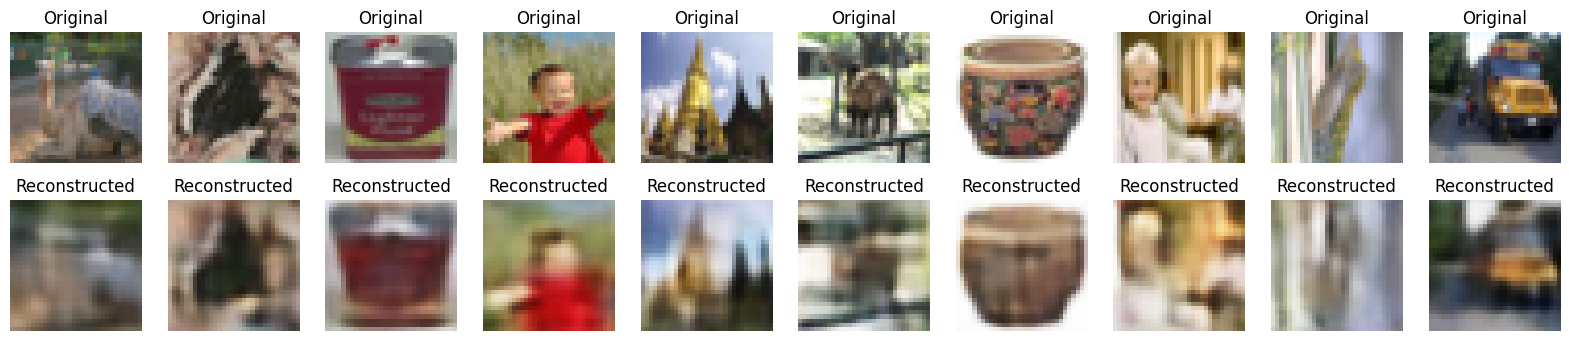

In [11]:
n = 10
sample_images = X_test_subset[:n]

# reconstructed images with the autoencoder
reconstructed_images = autoencoder.predict(sample_images)

# Plot original and reconstructed images
plt.figure(figsize=(20, 4))
for i in range(n):
    # original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(sample_images[i])
    plt.title("Original")
    plt.axis("off")
    
    #  reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_images[i])
    plt.title("Reconstructed")
    plt.axis("off")
plt.show()

In [12]:
encoder = Model(input_img, latent)

# Extract compressed representations for train and test data
latent_train = encoder.predict(X_train_subset)
latent_test = encoder.predict(X_test_subset)

# Flatten latent representations to vectors 
latent_train_flat = latent_train.reshape(latent_train.shape[0], -1)
latent_test_flat = latent_test.reshape(latent_test.shape[0], -1)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [13]:
# Train and evaluate 3-NN classifier on compressed latent space
knn_classifier_latent = KNeighborsClassifier(n_neighbors=3)
knn_classifier_latent.fit(latent_train_flat, y_train_subset)
y_pred_latent = knn_classifier_latent.predict(latent_test_flat)
accuracy_latent = accuracy_score(y_test_subset, y_pred_latent)
print("Ακρίβεια 3-NN στον latent χώρο: {:.2f}%".format(accuracy_latent * 100))

Ακρίβεια 3-NN στον latent χώρο: 44.30%


In [14]:
# Load ResNet50 without classification head, with global average pooling
resnet_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
"""
Takes a NumPy array of images (N, H, W, 3) with pixel values in [0, 1],
resizes them to the required input size (224x224), applies preprocessing using `preprocess_input`,
and returns the latent embeddings extracted by ResNet50.
"""
def extract_resnet_latent(images):
    
    # Reshape images to  224x224
    images_resized = tf.image.resize(images, (224, 224)).numpy()
    # Rescale images to [0, 255] and apply model-specific preprocessing
    images_pp = preprocess_input(images_resized * 255)
    # Extract embeddings from the model
    embeddings = resnet_model.predict(images_pp)
    return embeddings

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [15]:
# Extract latent embeddings for train and test data
latent_embeddings_train = extract_resnet_latent(X_train_subset)
latent_embeddings_test = extract_resnet_latent(X_test_subset)

print("Shape of latent embeddings (train):", latent_embeddings_train.shape)
print("Shape of latent embeddings (test):", latent_embeddings_test.shape)

157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
Shape of latent embeddings (train): (5000, 2048)
Shape of latent embeddings (test): (1000, 2048)


In [17]:
# Train and evaluate 3-NN classifier on ResNet50 embeddings
knn_classifier = KNeighborsClassifier(n_neighbors=3)
knn_classifier.fit(latent_embeddings_train, y_train_subset)
y_pred = knn_classifier.predict(latent_embeddings_test)
accuracy = accuracy_score(y_test_subset, y_pred)
print(" Accuracy of 3-Nearest Neighbors classifier on ResNet50 latent embeddings: {:.2f}%".format(accuracy * 100))

 Accuracy of 3-Nearest Neighbors classifier on ResNet50 latent embeddings: 88.10%


In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model, preprocess = clip.load("ViT-B/32", device=device)
"""
We set the model to evaluation mode since we are not training it, only using it for inference
Images are first converted to PIL format και στη συνέχεια
επεξεργάζονται με το official preprocess του CLIP.
"""

def extract_clip_embeddings(images):
   
    model.eval() 
    embeddings_list = []
    with torch.no_grad():
        for i in range(images.shape[0]):
            # Convert the image to PIL format (rescaling back to [0, 255])
            pil_img = Image.fromarray((images[i] * 255).astype(np.uint8))
            # Apply preprocessing 
            image_input = preprocess(pil_img).unsqueeze(0).to(device)
            # Extract the image embedding
            embedding = model.encode_image(image_input)
            # Apply L2 normalization to the embedding
            embedding = embedding / embedding.norm(dim=-1, keepdim=True)
            embeddings_list.append(embedding.cpu().numpy())
    embeddings = np.concatenate(embeddings_list, axis=0)
    return embeddings

# Extract CLIP embeddings for the training and test data
embeddings_train_clip = extract_clip_embeddings(X_train_subset)
embeddings_test_clip = extract_clip_embeddings(X_test_subset)

print("Shape of CLIP embeddings (training):", embeddings_train_clip.shape)
print("Shape of CLIP embeddings (test):", embeddings_test_clip.shape)


100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 178MiB/s]


Shape of CLIP embeddings (training): (5000, 512)
Shape of CLIP embeddings (test): (1000, 512)


In [21]:
# Train and evaluate 3-NN classifier on CLIP embeddings
knn_classifier_clip = KNeighborsClassifier(n_neighbors=3)
knn_classifier_clip.fit(embeddings_train_clip, y_train_subset)
y_pred_clip = knn_classifier_clip.predict(embeddings_test_clip)
accuracy_clip = accuracy_score(y_test_subset, y_pred_clip)
print(" Accuracy of 3-Nearest Neighbors classifier on CLIP embeddings: {:.2f}%".format(accuracy_clip * 100))

 Accuracy of 3-Nearest Neighbors classifier on CLIP embeddings: 92.60%


In [23]:
results = {
    "Raw Image Space": accuracy_original,
    "Autoencoder Latent Space": accuracy_latent,
    "ResNet50 Embeddings": accuracy,
    "CLIP Embeddings": accuracy_clip
}

for method, acc in results.items():
    print(f"{method}: {acc*100:.2f}%")

Raw Image Space: 35.60%
Autoencoder Latent Space: 44.30%
ResNet50 Embeddings: 88.10%
CLIP Embeddings: 92.60%


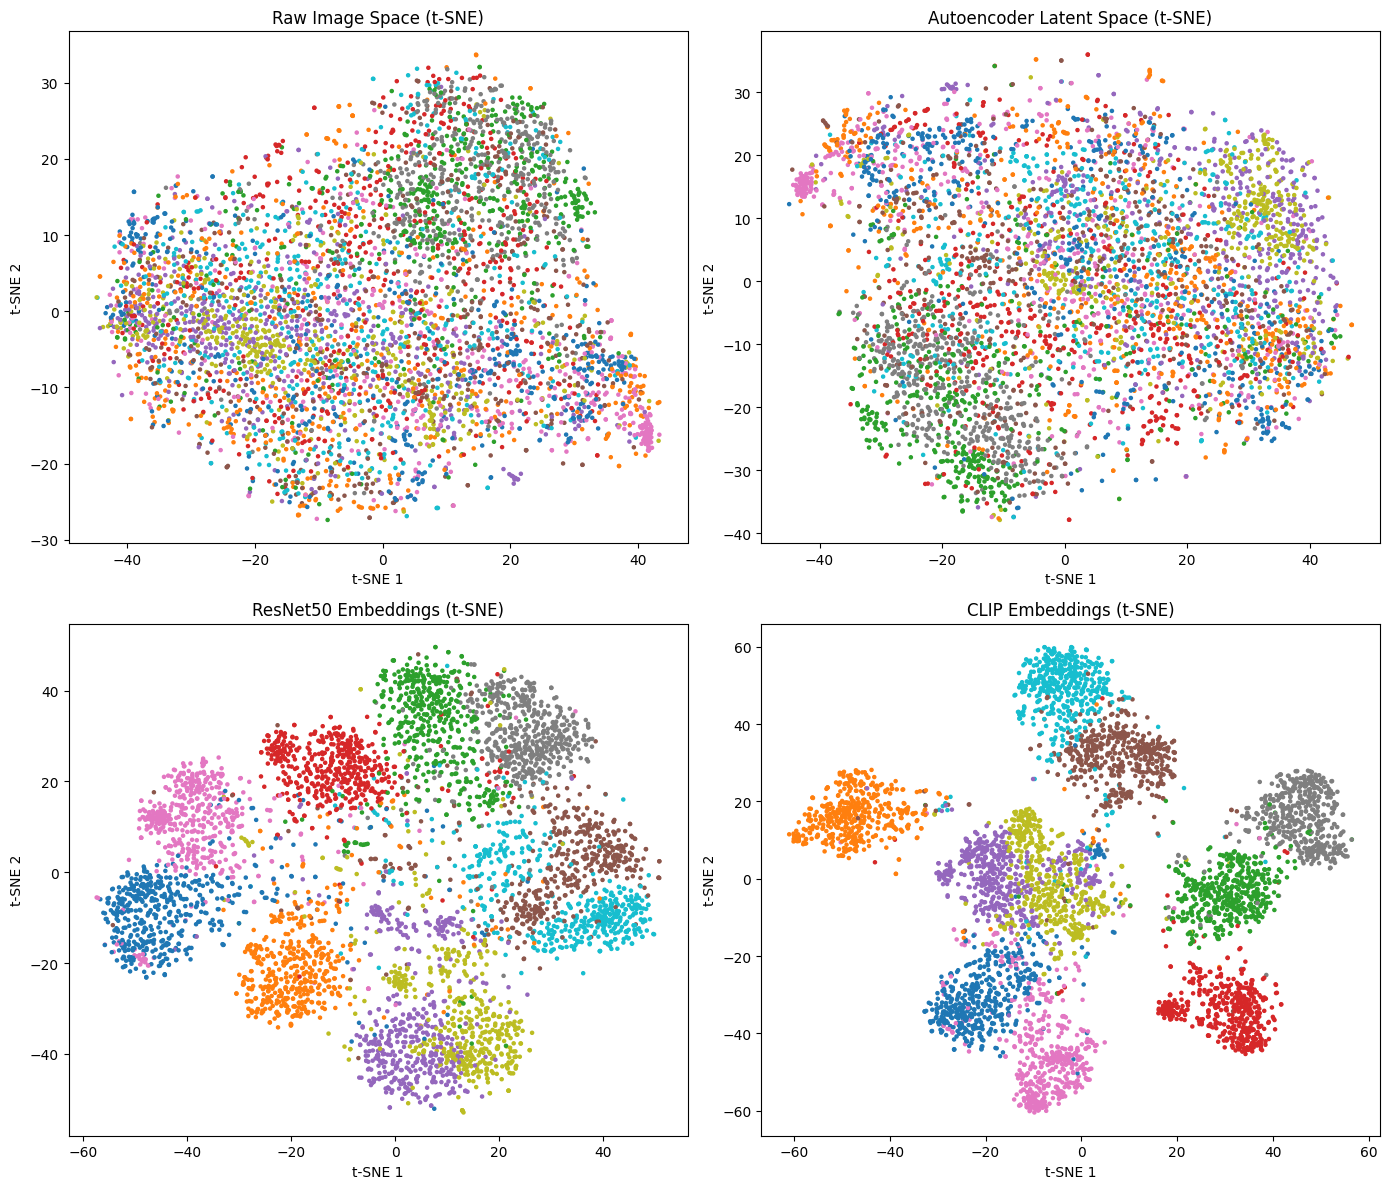

In [27]:
#Lets visualize the results in 2D 
from sklearn.manifold import TSNE

# Run t-SNE for each type of representation
tsne_raw = TSNE(n_components=2, perplexity=40, random_state=42)
tsne_autoencoder = TSNE(n_components=2, perplexity=40, random_state=42)
tsne_resnet = TSNE(n_components=2, perplexity=40, random_state=42)
tsne_clip = TSNE(n_components=2, perplexity=40, random_state=42)

raw_2d = tsne_raw.fit_transform(X_train_flat)
autoencoder_2d = tsne_autoencoder.fit_transform(latent_train_flat)
resnet_2d = tsne_resnet.fit_transform(latent_embeddings_train)
clip_2d = tsne_clip.fit_transform(embeddings_train_clip)

# Plot all 4 in one figure
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

axes[0, 0].scatter(raw_2d[:, 0], raw_2d[:, 1], c=y_train_subset, cmap='tab10', s=5)
axes[0, 0].set_title("Raw Image Space (t-SNE)")

axes[0, 1].scatter(autoencoder_2d[:, 0], autoencoder_2d[:, 1], c=y_train_subset, cmap='tab10', s=5)
axes[0, 1].set_title("Autoencoder Latent Space (t-SNE)")

axes[1, 0].scatter(resnet_2d[:, 0], resnet_2d[:, 1], c=y_train_subset, cmap='tab10', s=5)
axes[1, 0].set_title("ResNet50 Embeddings (t-SNE)")

axes[1, 1].scatter(clip_2d[:, 0], clip_2d[:, 1], c=y_train_subset, cmap='tab10', s=5)
axes[1, 1].set_title("CLIP Embeddings (t-SNE)")

for ax in axes.flat:
    ax.set_xlabel("t-SNE 1")
    ax.set_ylabel("t-SNE 2")

plt.tight_layout()
plt.show()
